##Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
from skimage.filters import threshold_otsu

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Retinal Image



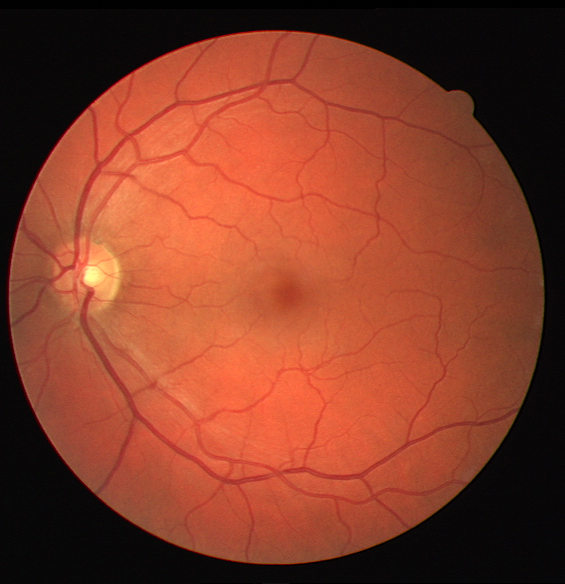

In [31]:
import cv2
from google.colab.patches import cv2_imshow

# Load the image
image_path = '/content/drive/MyDrive/DIP Project/archive (9)/DRIVE/training/images/35_training.tif'
image = cv2.imread(image_path)

# Display the original Image
cv2_imshow(image)
# cv2_imshow(grayscale_image)


##Splitting the retinal image into red green and blue channels.

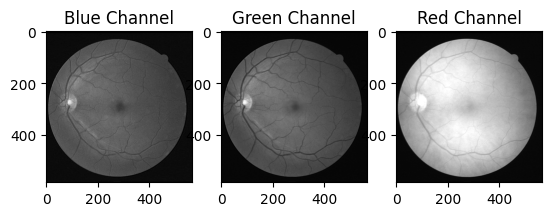

In [32]:
# Split the image into RGB channels
blue_channel, green_channel, red_channel = cv2.split(image)

# Save each channel as a separate image
cv2.imwrite('/content/drive/MyDrive/DIP Project/Retinal_blue_channel.png', blue_channel)
cv2.imwrite('/content/drive/MyDrive/DIP Project/Retinal_green_channel.png', green_channel)
cv2.imwrite('/content/drive/MyDrive/DIP Project/Retinal_red_channel.png', red_channel)

# Display each channel
plt.subplot(1, 3, 1)
plt.imshow(blue_channel, cmap='gray')
plt.title('Blue Channel')

plt.subplot(1, 3, 2)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')

plt.subplot(1, 3, 3)
plt.imshow(red_channel, cmap='gray')
plt.title('Red Channel')

plt.show()

Applying Histogram Equalization and Gaussian Blur to Green Channel Image

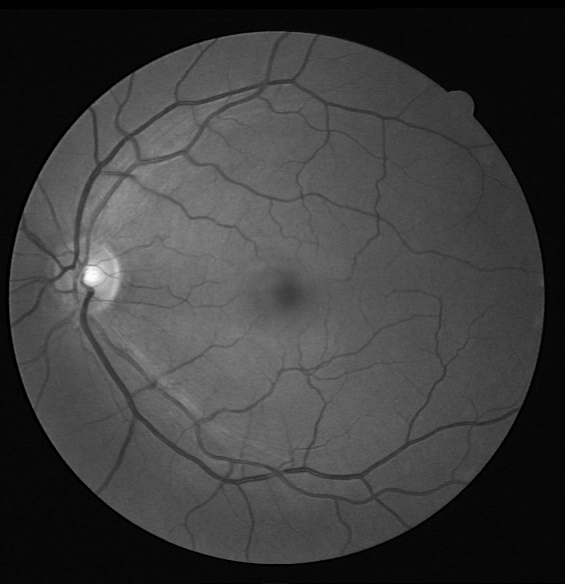

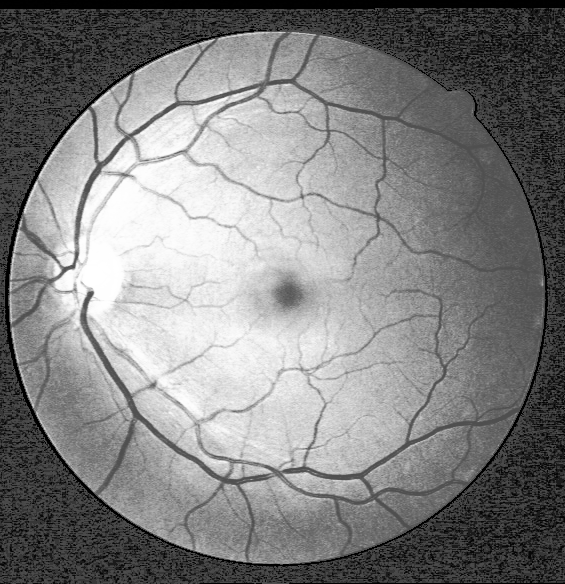

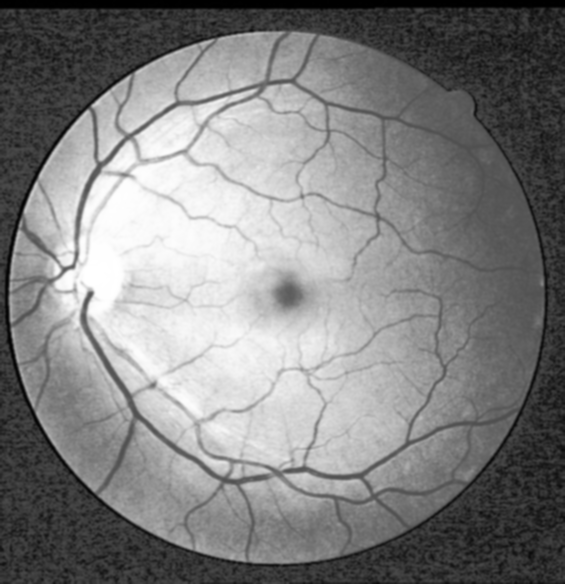

In [54]:
# Perform histogram equalization
equalized_image = cv2.equalizeHist(green_channel)

# Perform Gaussian blur
blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)

# Save the preprocessed images
cv2.imwrite('/content/drive/MyDrive/DIP Project/Retinal_green_channel_equalized.png', equalized_image)
cv2.imwrite('/content/drive/MyDrive/DIP Project/Retinal_green_channel_blurred.png', blurred_image)

# Display the original green channel image, the equalized image, and the blurred image
cv2_imshow(green_channel)
cv2_imshow(equalized_image)
cv2_imshow(blurred_image)


###Applying Adaptive Histogram Equalization(CLAHE) on the Green Channel Image

Text(0.5, 1.0, 'Adaptive Histogram Equalization')

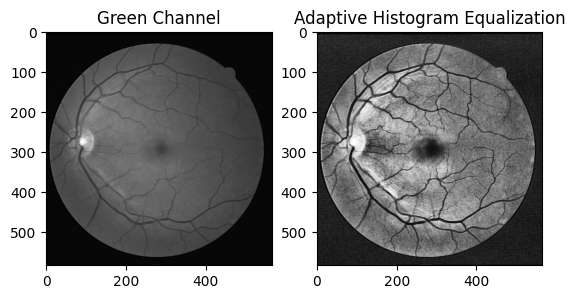

In [27]:
# Create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8))

# Apply CLAHE to the green channel
clahe_image = clahe.apply(green_channel)

# Save the preprocessed image
cv2.imwrite('/content/drive/MyDrive/DIP Project/Retinal_green_channel_clahe.png', clahe_image)

# Display the original green channel image and the CLAHE-enhanced image
plt.subplot(1, 2, 1)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')

plt.subplot(1, 2, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title('Adaptive Histogram Equalization')


###Using Frangi Filter and Normalization on the CLAHE image

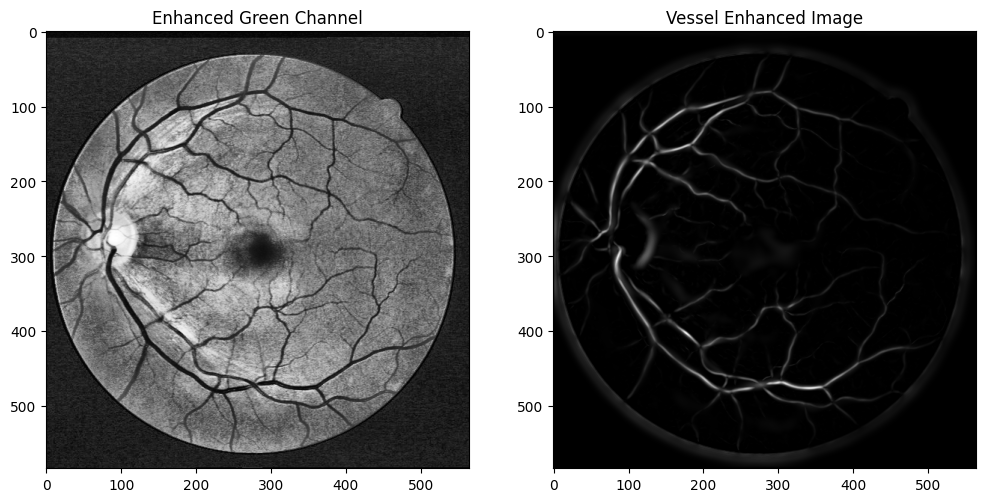

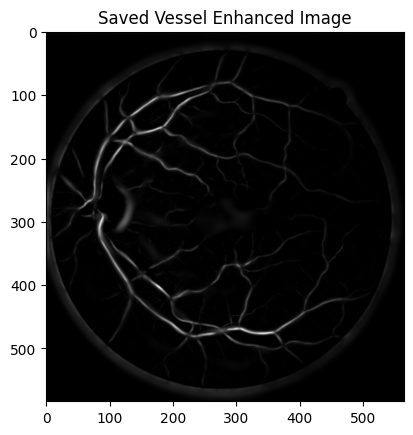

In [34]:
from scipy.ndimage import gaussian_filter
from skimage.filters import frangi
sigma = 0.15  # Adjust the sigma value
vessel_enhanced = frangi(clahe_image)
vessel_enhanced = gaussian_filter(vessel_enhanced, sigma)
vessel_enhanced = (vessel_enhanced - np.min(vessel_enhanced)) / (np.max(vessel_enhanced) - np.min(vessel_enhanced))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(clahe_image, cmap='gray')
plt.title('Enhanced Green Channel')

plt.subplot(1, 2, 2)
plt.imshow(vessel_enhanced, cmap='gray')
plt.title('Vessel Enhanced Image')
# Save the vessel-enhanced image
cv2.imwrite('/content/vessel_enhanced_image.jpg', (vessel_enhanced * 255).astype('uint8'))

# Display the saved vessel-enhanced image
plt.figure()
plt.imshow(cv2.imread('/content/vessel_enhanced_image.jpg'), cmap='gray')
plt.title('Saved Vessel Enhanced Image')

# Show the plots
plt.show()


##Morphological Dilation and Adaptive Thresholding

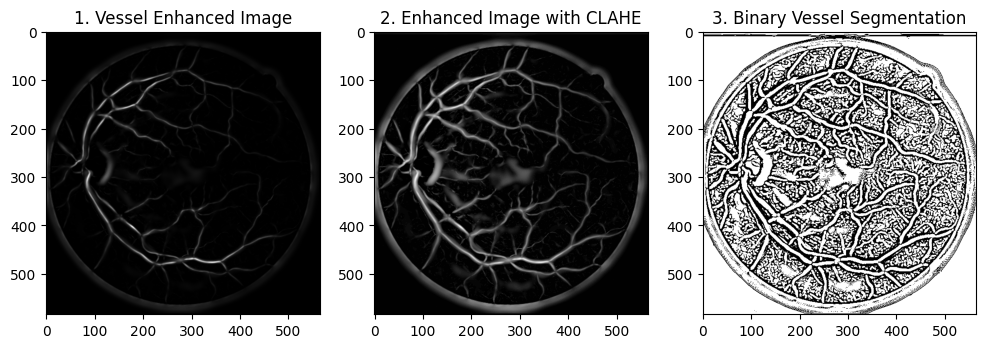

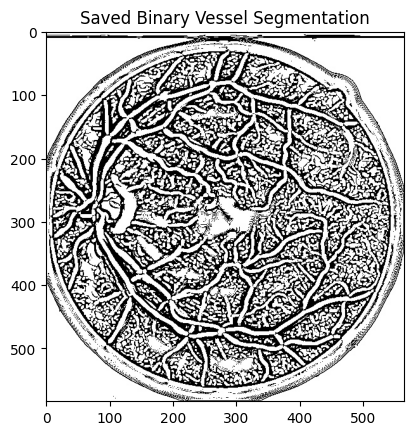

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Check if the image is grayscale or has more than one channel
if len(vessel_enhanced.shape) == 2:
    # Image is already grayscale
    vessel_enhanced_gray = vessel_enhanced
elif len(vessel_enhanced.shape) == 3 and vessel_enhanced.shape[2] == 3:
    # Image is BGR, convert to grayscale
    vessel_enhanced_gray = cv2.cvtColor(vessel_enhanced, cv2.COLOR_BGR2GRAY)
else:
    # Handle other cases as needed
    raise ValueError("Unsupported image format")

# Normalize the grayscale image to the range [0, 255]
vessel_enhanced_normalized = cv2.normalize(vessel_enhanced_gray, None, 0, 255, cv2.NORM_MINMAX)

# Ensure the image is 8-bit
vessel_enhanced_8bit = np.uint8(vessel_enhanced_normalized)

# Apply CLAHE for local contrast enhancement
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
enhanced_clahe = clahe.apply(vessel_enhanced_8bit)

# Apply morphological dilation
kernel = np.ones((3, 3), np.uint8)
binary_vessels = cv2.dilate(enhanced_clahe, kernel, iterations=1)

# Apply adaptive thresholding
binary_vessels = cv2.adaptiveThreshold(
    binary_vessels, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)

# Display the vessel-enhanced image and the binary vessel segmentation
plt.figure(figsize=(12, 6))

# Plot the vessel-enhanced image
plt.subplot(1, 3, 1)
plt.imshow(vessel_enhanced, cmap='gray')
plt.title('1. Vessel Enhanced Image')

# Plot the enhanced image with CLAHE
plt.subplot(1, 3, 2)
plt.imshow(enhanced_clahe, cmap='gray')
plt.title('2. Enhanced Image with CLAHE')

# Plot the binary vessel segmentation
plt.subplot(1, 3, 3)
plt.imshow(binary_vessels, cmap='gray')
plt.title('3. Binary Vessel Segmentation')

# Save the binary vessel segmentation image
binary_vessels_path = '/content/binary_vessels_combined.jpg'
cv2.imwrite(binary_vessels_path, binary_vessels)

# Save the binary vessel segmentation image
enhanced_clahe_path = '/content/Enhanced Image with CLAHE.jpg'
cv2.imwrite(enhanced_clahe_path, enhanced_clahe)

# Display the saved binary vessel segmentation image
plt.figure()
plt.imshow(cv2.imread(binary_vessels_path), cmap='gray')
plt.title('Saved Binary Vessel Segmentation')

# Show the plots
plt.show()


###Using Otsu Thresholding

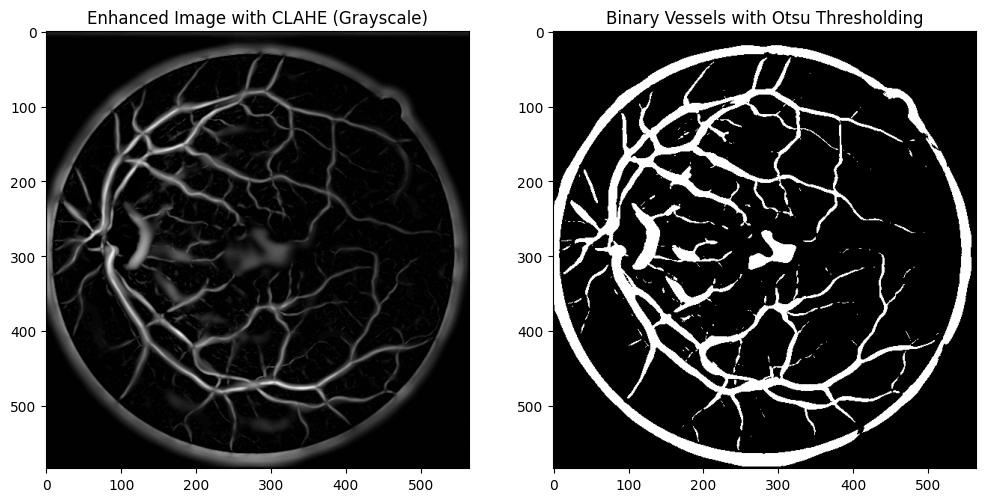

Binary Vessels Image with Otsu Thresholding saved at: /content/binary_vessels_otsu.jpg


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Convert the image to grayscale if it's not already
if len(binary_vessels.shape) > 2:
    enhanced_clahe_gray = cv2.cvtColor(enhanced_clahe, cv2.COLOR_BGR2GRAY)
else:
    enhanced_clahe_gray = enhanced_clahe

# Apply Otsu's thresholding
_, binary_vessels_otsu = cv2.threshold(enhanced_clahe_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(enhanced_clahe_gray, cmap='gray')
plt.title('Enhanced Image with CLAHE (Grayscale)')

plt.subplot(1, 2, 2)
plt.imshow(binary_vessels_otsu, cmap='gray')
plt.title('Binary Vessels with Otsu Thresholding')

# Save the binary vessels image with Otsu thresholding
binary_vessels_otsu_path = '/content/binary_vessels_otsu.jpg'
cv2.imwrite(binary_vessels_otsu_path, binary_vessels_otsu)

# Show the plots
plt.show()

# Provide download link for the binary vessels image with Otsu thresholding
print(f"Binary Vessels Image with Otsu Thresholding saved at: {binary_vessels_otsu_path}")


In [37]:
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from skimage import io, color

# Load the segmented and ground truth images
segmented_image = cv2.imread("/content/binary_vessels_otsu.jpg", cv2.IMREAD_GRAYSCALE)
ground_truth_image = io.imread("/content/drive/MyDrive/DIP Project/archive (9)/DRIVE/training/1st_manual/35_manual1.gif")

# Binarize the images (assuming vessel pixels are non-zero in both images)
segmented_binary = (segmented_image > 0).astype(int)
ground_truth_binary = (ground_truth_image > 0).astype(int)

# Flatten the images to 1D arrays
segmented_flat = segmented_binary.flatten()
ground_truth_flat = ground_truth_binary.flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, segmented_flat)
precision = precision_score(ground_truth_flat, segmented_flat)
recall = recall_score(ground_truth_flat, segmented_flat)
f1 = f1_score(ground_truth_flat, segmented_flat)

# Calculate ROC-AUC
roc_auc = roc_auc_score(ground_truth_flat, segmented_flat)

# Calculate Precision-Recall curve and AUC-PR
precision_curve, recall_curve, _ = precision_recall_curve(ground_truth_flat, segmented_flat)
pr_auc = auc(recall_curve, precision_curve)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'AUC-PR: {pr_auc:.4f}')


Accuracy: 0.8060
Precision: 0.2778
Recall: 0.7737
F1 Score: 0.4088
ROC-AUC: 0.7914
AUC-PR: 0.5356


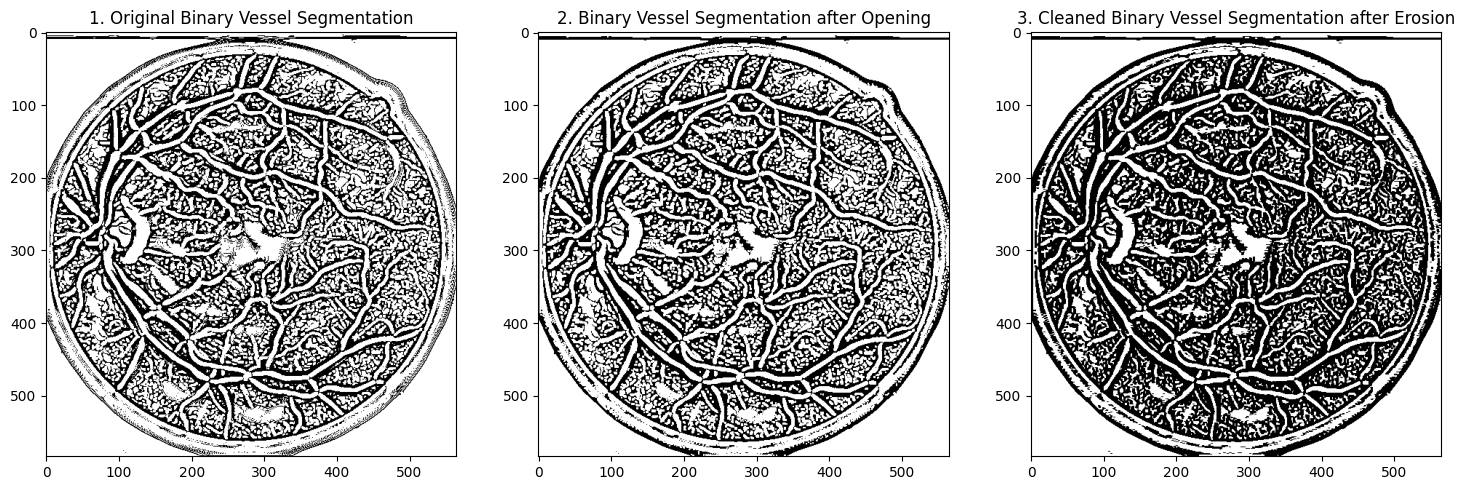

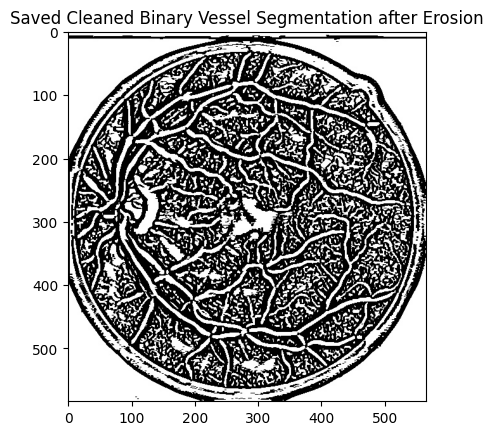

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Apply morphological opening to remove small bright structures (noise)
kernel_opening = np.ones((2, 2), np.uint8)
binary_vessels_opened = cv2.morphologyEx(binary_vessels, cv2.MORPH_OPEN, kernel_opening, iterations=1)

# Apply erosion to further remove noise and thin the vessels
kernel_erosion = np.ones((1, 3), np.uint8)
binary_vessels_cleaned = cv2.erode(binary_vessels_opened, kernel_erosion, iterations=1)

# Display the original binary vessel segmentation, opened version, and cleaned version
plt.figure(figsize=(18, 6))

# Plot the original binary vessel segmentation
plt.subplot(1, 3, 1)
plt.imshow(binary_vessels, cmap='gray')
plt.title('1. Original Binary Vessel Segmentation')

# Plot the binary vessel segmentation after morphological opening
plt.subplot(1, 3, 2)
plt.imshow(binary_vessels_opened, cmap='gray')
plt.title('2. Binary Vessel Segmentation after Opening')

# Plot the cleaned binary vessel segmentation after erosion
plt.subplot(1, 3, 3)
plt.imshow(binary_vessels_cleaned, cmap='gray')
plt.title('3. Cleaned Binary Vessel Segmentation after Erosion')

# Save the cleaned binary vessel segmentation after erosion
binary_vessels_cleaned_path = '/content/binary_vessels_cleaned.jpg'
cv2.imwrite(binary_vessels_cleaned_path, binary_vessels_cleaned)

# Display the saved cleaned binary vessel segmentation after erosion
plt.figure()
plt.imshow(cv2.imread(binary_vessels_cleaned_path), cmap='gray')
plt.title('Saved Cleaned Binary Vessel Segmentation after Erosion')

# Show the plots
plt.show()


##Erosion with larger kernel, Darkening of Background and clipping of pixel values.

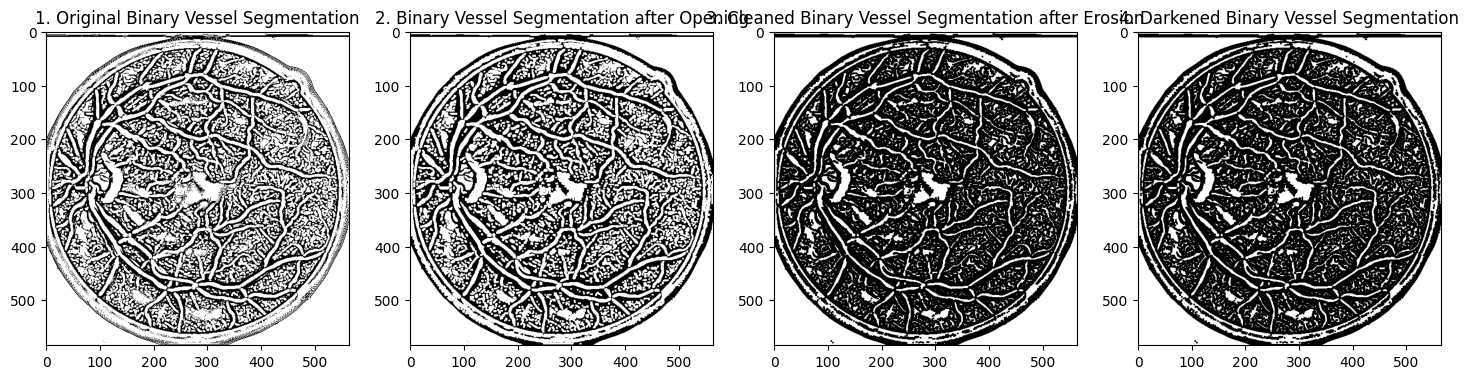

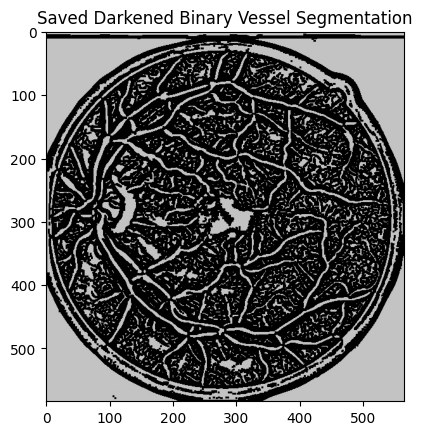

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Apply morphological opening to remove small bright structures (noise)
kernel_opening = np.ones((3, 3), np.uint8)
binary_vessels_opened = cv2.morphologyEx(binary_vessels, cv2.MORPH_OPEN, kernel_opening, iterations=1)

# Apply a larger erosion to further remove noise and thin the vessels
kernel_erosion = np.ones((3, 3), np.uint8)
binary_vessels_cleaned = cv2.erode(binary_vessels_opened, kernel_erosion, iterations=1)

# Darken the background by subtracting a value
darkened_binary_vessels = binary_vessels_cleaned.astype(np.int32) - 60  # Adjust the subtraction value as needed

# Clip pixel values to ensure they are in the valid range [0, 255]
darkened_binary_vessels = np.clip(darkened_binary_vessels, 0, 255).astype(np.uint8)

# Display the original binary vessel segmentation, opened version, and cleaned version
plt.figure(figsize=(18, 6))

# Plot the original binary vessel segmentation
plt.subplot(1, 4, 1)
plt.imshow(binary_vessels, cmap='gray')
plt.title('1. Original Binary Vessel Segmentation')

# Plot the binary vessel segmentation after morphological opening
plt.subplot(1, 4, 2)
plt.imshow(binary_vessels_opened, cmap='gray')
plt.title('2. Binary Vessel Segmentation after Opening')

# Plot the cleaned binary vessel segmentation after erosion
plt.subplot(1, 4, 3)
plt.imshow(binary_vessels_cleaned, cmap='gray')
plt.title('3. Cleaned Binary Vessel Segmentation after Erosion')

# Plot the darkened binary vessel segmentation
plt.subplot(1, 4, 4)
plt.imshow(darkened_binary_vessels, cmap='gray')
plt.title('4. Darkened Binary Vessel Segmentation')

# Save the darkened binary vessel segmentation
darkened_binary_vessels_path = '/content/darkened_binary_vessels.jpg'
cv2.imwrite(darkened_binary_vessels_path, darkened_binary_vessels)

# Display the saved darkened binary vessel segmentation
plt.figure()
plt.imshow(cv2.imread(darkened_binary_vessels_path), cmap='gray')
plt.title('Saved Darkened Binary Vessel Segmentation')

# Show the plots
plt.show()


##Contour Image from Darkened Binary Vessel

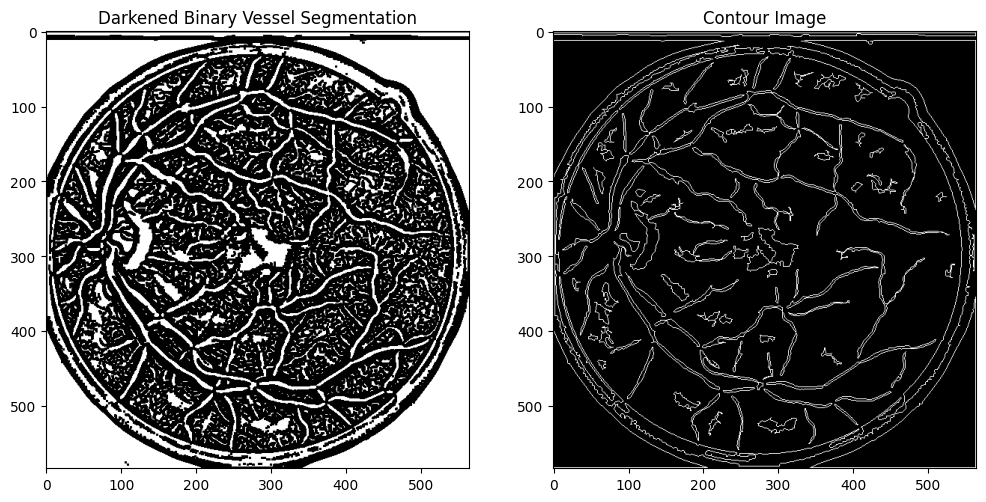

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the darkened binary vessel segmentation image
darkened_binary_vessels_path = '/content/darkened_binary_vessels.jpg'
darkened_binary_vessels = cv2.imread(darkened_binary_vessels_path, cv2.IMREAD_GRAYSCALE)

# Ensure the image is binary (threshold if necessary)
_, darkened_binary_vessels = cv2.threshold(darkened_binary_vessels, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary vessel segmentation image
contours, _ = cv2.findContours(darkened_binary_vessels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area
min_contour_area = 50  # Adjust this value
contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

# Filter contours based on perimeter
min_contour_perimeter = 10  # Adjust this value
contours = [cnt for cnt in contours if cv2.arcLength(cnt, True) > min_contour_perimeter]

# Create a blank image to draw the contours
contour_image = np.zeros_like(darkened_binary_vessels)

# Draw the contours on the blank image
cv2.drawContours(contour_image, contours, -1, 255, 1)

# Display the original darkened binary vessel segmentation and the contour image
plt.figure(figsize=(12, 6))

# Plot the original darkened binary vessel segmentation
plt.subplot(1, 2, 1)
plt.imshow(darkened_binary_vessels, cmap='gray')
plt.title('Darkened Binary Vessel Segmentation')

# Plot the contour image
plt.subplot(1, 2, 2)
plt.imshow(contour_image, cmap='gray')
plt.title('Contour Image')

# Show the plots
plt.show()


Method 2

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import color, data, filters, graph, measure, morphology


Loading the Image

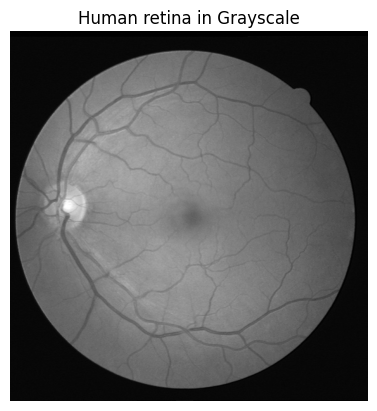

In [9]:
import cv2
import matplotlib.pyplot as plt

retina_source = cv2.imread("/content/drive/MyDrive/DIP Project/archive (9)/DRIVE/training/images/35_training.tif", cv2.IMREAD_GRAYSCALE)

_, ax = plt.subplots()
ax.imshow(retina_source, cmap='gray')
ax.set_axis_off()
_ = ax.set_title('Human retina in Grayscale')

plt.show()


Multi-Otsu Thresholding, Sato Vesselness Filter

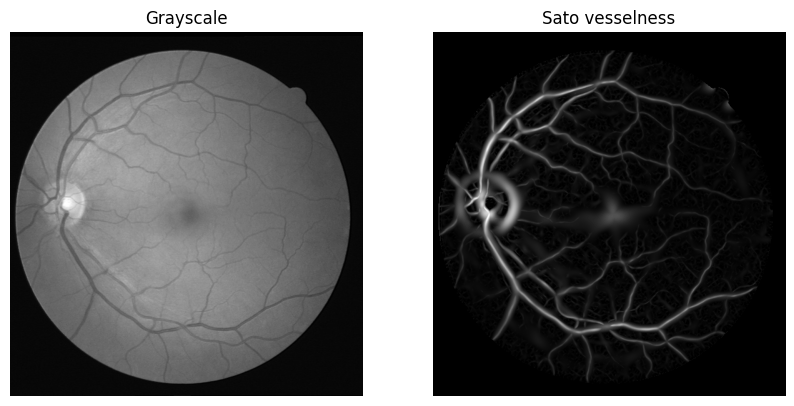

In [52]:
import cv2
import numpy as np
from skimage import color, filters
import matplotlib.pyplot as plt

# Load the image
retina_source = cv2.imread("/content/drive/MyDrive/DIP Project/archive (9)/DRIVE/training/images/35_training.tif")

# Convert the image to grayscale
retina_gray = cv2.cvtColor(retina_source, cv2.COLOR_BGR2GRAY)

# Apply vesselness filter
t0, t1 = filters.threshold_multiotsu(retina_gray, classes=3)
mask = (retina_gray > t0)
sato_vessels = filters.sato(retina_gray, sigmas=range(1, 10)) * mask

# Display the results
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(retina_gray, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('Grayscale')

axes[1].imshow(sato_vessels, cmap='gray')
axes[1].set_axis_off()
axes[1].set_title('Sato vesselness')
plt.show()


###Hysteresis Thresholding

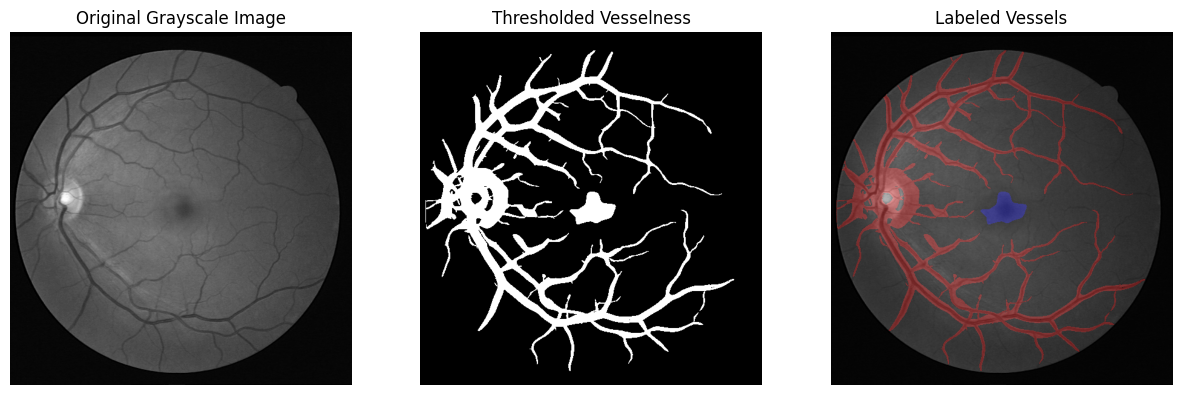

In [64]:
import cv2
import numpy as np
from skimage import color, filters, morphology, measure
import matplotlib.pyplot as plt

# Assuming 'retina' is the grayscale image
retina = cv2.imread("/content/drive/MyDrive/DIP Project/Retinal_green_channel.png", cv2.IMREAD_GRAYSCALE)

# Apply vesselness filter
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

# Apply hysteresis thresholding
thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)

# Save the thresholded vesselness image
cv2.imwrite("/content/thresholded_vesselness.jpg", (thresholded * 255).astype(np.uint8))

# Label connected components
labeled = morphology.label(thresholded)

# Display the results
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('Original Grayscale Image')

axes[1].imshow(thresholded, cmap='gray')
axes[1].set_axis_off()
axes[1].set_title('Thresholded Vesselness')

# Convert labeled image to RGB using label2rgb
labeled_rgb = color.label2rgb(labeled, image=retina, bg_label=0)

axes[2].imshow(labeled_rgb)
axes[2].set_axis_off()
axes[2].set_title('Labeled Vessels')

plt.show()


In [65]:
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from skimage import io, color

# Load the segmented and ground truth images
segmented_image = cv2.imread("/content/thresholded_vesselness.jpg", cv2.IMREAD_GRAYSCALE)
ground_truth_image = io.imread("/content/drive/MyDrive/DIP Project/archive (9)/DRIVE/training/1st_manual/35_manual1.gif")

# Binarize the images (assuming vessel pixels are non-zero in both images)
segmented_binary = (segmented_image > 0).astype(int)
ground_truth_binary = (ground_truth_image > 0).astype(int)

# Flatten the images to 1D arrays
segmented_flat = segmented_binary.flatten()
ground_truth_flat = ground_truth_binary.flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, segmented_flat)
precision = precision_score(ground_truth_flat, segmented_flat)
recall = recall_score(ground_truth_flat, segmented_flat)
f1 = f1_score(ground_truth_flat, segmented_flat)

# Calculate ROC-AUC
roc_auc = roc_auc_score(ground_truth_flat, segmented_flat)

# Calculate Precision-Recall curve and AUC-PR
precision_curve, recall_curve, _ = precision_recall_curve(ground_truth_flat, segmented_flat)
pr_auc = auc(recall_curve, precision_curve)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'AUC-PR: {pr_auc:.4f}')


Accuracy: 0.8684
Precision: 0.3786
Recall: 0.8076
F1 Score: 0.5156
ROC-AUC: 0.8409
AUC-PR: 0.6015


##Segmented Vessels output using Otsu and other morphological operations on the Vessels Only Image.

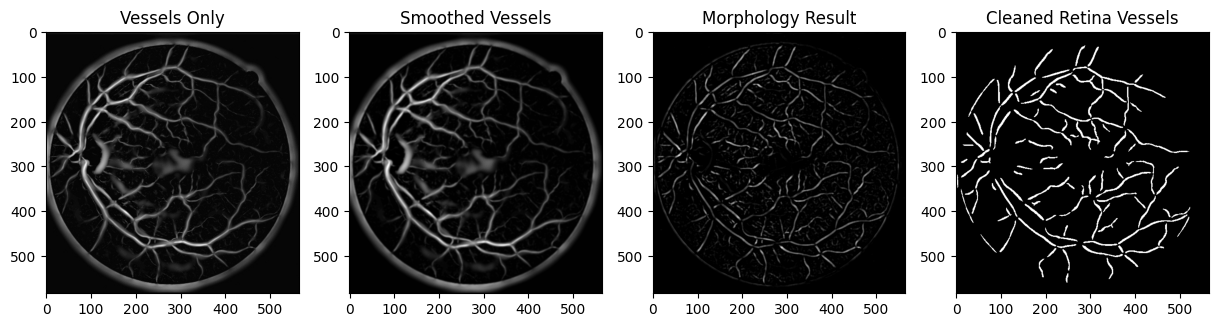

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.filters import threshold_otsu

# Load the vessels only image
clahe_image_path = '/content/Enhanced Image with CLAHE.jpg'
vessels_only = cv2.imread(clahe_image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian smoothing to reduce noise
smoothed_vessels = cv2.GaussianBlur(vessels_only, (5, 5), 0)

# Apply adaptive histogram equalization for better contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_vessels = clahe.apply(smoothed_vessels)

# Apply morphological operations for vessel enhancement
kernel = np.ones((5, 5), np.uint8)
morphology_result = cv2.morphologyEx(enhanced_vessels, cv2.MORPH_TOPHAT, kernel)

# Adaptive thresholding using Otsu's method
thresh = threshold_otsu(morphology_result)
binary_retina_vessels = morphology_result > thresh

# Remove small connected components (noise) using morphology
cleaned_retina_vessels = morphology.remove_small_objects(binary_retina_vessels, min_size=60)

# Convert to uint8 before saving
cleaned_retina_vessels_uint8 = (cleaned_retina_vessels * 255).astype(np.uint8)

# Display the results with a more suitable colormap
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(vessels_only, cmap='gray')
plt.title('Vessels Only')

plt.subplot(1, 4, 2)
plt.imshow(smoothed_vessels, cmap='gray')
plt.title('Smoothed Vessels')

plt.subplot(1, 4, 3)
plt.imshow(morphology_result, cmap='gray')
plt.title('Morphology Result')

plt.subplot(1, 4, 4)
plt.imshow(cleaned_retina_vessels, cmap='gray')
plt.title('Cleaned Retina Vessels')

# Save the binary vessel segmentation image
cleaned_retina_vessels_path = '/content/cleaned_retina_vessels.jpg'
cv2.imwrite(cleaned_retina_vessels_path, cleaned_retina_vessels_uint8)
plt.show()


In [68]:
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
from skimage import io, color

# Load the segmented and ground truth images
segmented_image = cv2.imread("/content/cleaned_retina_vessels.jpg", cv2.IMREAD_GRAYSCALE)
ground_truth_image = io.imread("/content/drive/MyDrive/DIP Project/archive (9)/DRIVE/training/1st_manual/35_manual1.gif")

# Binarize the images (assuming vessel pixels are non-zero in both images)
segmented_binary = (segmented_image > 0).astype(int)
ground_truth_binary = (ground_truth_image > 0).astype(int)

# Flatten the images to 1D arrays
segmented_flat = segmented_binary.flatten()
ground_truth_flat = ground_truth_binary.flatten()

# Calculate metrics
accuracy = accuracy_score(ground_truth_flat, segmented_flat)
precision = precision_score(ground_truth_flat, segmented_flat)
recall = recall_score(ground_truth_flat, segmented_flat)
f1 = f1_score(ground_truth_flat, segmented_flat)

# Calculate ROC-AUC
roc_auc = roc_auc_score(ground_truth_flat, segmented_flat)

# Calculate Precision-Recall curve and AUC-PR
precision_curve, recall_curve, _ = precision_recall_curve(ground_truth_flat, segmented_flat)
pr_auc = auc(recall_curve, precision_curve)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'AUC-PR: {pr_auc:.4f}')


Accuracy: 0.8990
Precision: 0.4437
Recall: 0.6478
F1 Score: 0.5266
ROC-AUC: 0.7853
AUC-PR: 0.5610
